In [42]:
using Graphs
using GraphPlot
using Combinatorics
using GraphIO
using Plots

function density(g)
    ne(g) / nv(g)
end

density (generic function with 1 method)

In [43]:
graphs = loadgraphs("datasets/graphs.lg")

Dict{String, AbstractGraph} with 100 entries:
  "3"   => SimpleGraph{Int64}(143, [[2, 3, 5, 7, 9, 21, 28, 30, 31, 34, 37], [1…
  "309" => SimpleGraph{Int64}(353, [[49], [5, 8, 9, 17, 20, 22, 31, 32, 33, 38,…
  "1"   => SimpleGraph{Int64}(188, [[4, 6, 7, 13, 14, 22, 26, 33, 36, 37, 40], …
  "74"  => SimpleGraph{Int64}(120, [[30], [17, 24, 25, 28, 30], [17, 30], [6, 9…
  "51"  => SimpleGraph{Int64}(127, [[2, 3, 6, 9, 17, 27], [1, 3, 4, 8, 9, 10, 1…
  "335" => SimpleGraph{Int64}(226, [[2, 7, 10, 13, 16, 21, 28, 36, 39], [1, 6, …
  "236" => SimpleGraph{Int64}(97, [[2, 3, 5, 6, 8, 9, 11, 12, 14, 15, 16, 18], …
  "27"  => SimpleGraph{Int64}(179, [[12, 15, 38, 43, 50], [20, 27, 50], [50], […
  "75"  => SimpleGraph{Int64}(108, [[7, 11, 12, 13, 15, 17, 18, 19, 22, 24, 26,…
  "296" => SimpleGraph{Int64}(216, [[48, 49], [8, 10, 13, 17, 18, 20, 22, 27, 2…
  "33"  => SimpleGraph{Int64}(181, [[3, 4, 7, 8, 9, 11, 16, 35, 37, 43], [6, 10…
  "28"  => SimpleGraph{Int64}(158, [[26, 30, 51], [6, 12, 16, 1

Distribution of size of graphs:

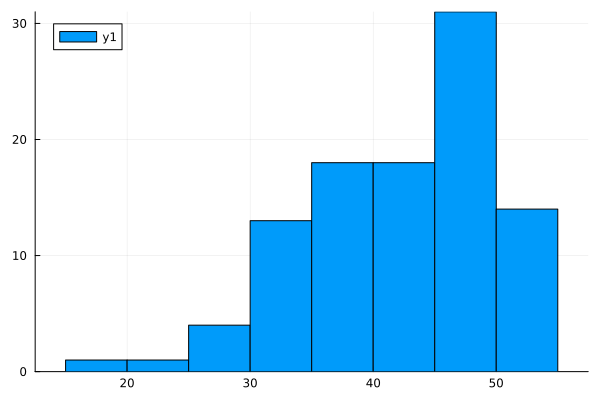

In [45]:
histogram([nv(g) for (key, g) in graphs])

Choosing a k value:

In [47]:
K = 15

15

# Preprocessing

In [48]:
"Estimate the DamkS using the greedy approach"
function greedy_damks_estimate(g, k)
    h = deepcopy(g)
    # Remove vertices with minimum degree until the graph has `k` vertices left
    for c in 1:(nv(g) - k)
        min_d, min_v = findmin(v -> length(neighbors(h, v)), vertices(h))
        rem_vertex!(h, min_v)
    end
    # Remove vertices to check for better density
    max_d = density(h)
    best_g = deepcopy(h)
    for c in 1:min(k-1, nv(h))
        min_d, min_v = findmin(v -> length(neighbors(h, v)), vertices(h))
        rem_vertex!(h, min_v)
        if density(h) > max_d
            max_d = density(h)
            best_g = deepcopy(h)
        end
    end
    best_g
end

"Prune vertices that have degree lower than `d`"
function prune_graph(g, d)
    can_rem = true
    h = deepcopy(g)
    while can_rem
        to_be_rem = Vector{Int64}()
        for v in 1:nv(h)
            if length(neighbors(h, v)) < d
                push!(to_be_rem, v)
            end
        end
        can_rem = length(to_be_rem) > 0
        rem_vertices!(h, to_be_rem)
    end
    h
end

prune_graph

Pruning

In [49]:
pruned = Dict(key => prune_graph(g, density(greedy_damks_estimate(g, K))) for (key, g) in graphs)

Dict{String, SimpleGraph{Int64}} with 100 entries:
  "309" => SimpleGraph{Int64}(312, [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  28, 29,…
  "30"  => SimpleGraph{Int64}(146, [[4, 7, 10, 13, 14, 16, 19, 22], [4, 8, 9, 1…
  "1"   => SimpleGraph{Int64}(156, [[4, 6, 7, 9, 12, 13, 14, 20, 22, 26], [5, 6…
  "74"  => SimpleGraph{Int64}(97, [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…
  "51"  => SimpleGraph{Int64}(115, [[2, 3, 5, 9, 17], [1, 3, 4, 5, 8, 9, 10, 11…
  "335" => SimpleGraph{Int64}(187, [[2, 3, 6, 7, 10, 13, 16, 21, 28], [1, 3, 6,…
  "236" => SimpleGraph{Int64}(90, [[2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15], […
  "27"  => SimpleGraph{Int64}(132, [[2, 12, 14, 15, 19], [1, 3, 4, 5, 6, 7, 8, …
  "75"  => SimpleGraph{Int64}(94, [[2, 5, 6, 7, 9, 11, 12, 13, 15, 17, 18, 19],…
  "296" => SimpleGraph{Int64}(156, [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  16, 17,…
  "33"  => SimpleGraph{Int64}(76, [[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]…
  "28"  => SimpleGraph{Int64}(108, [[2, 3, 4, 5, 6, 7, 8, 

Size distribution after pruning

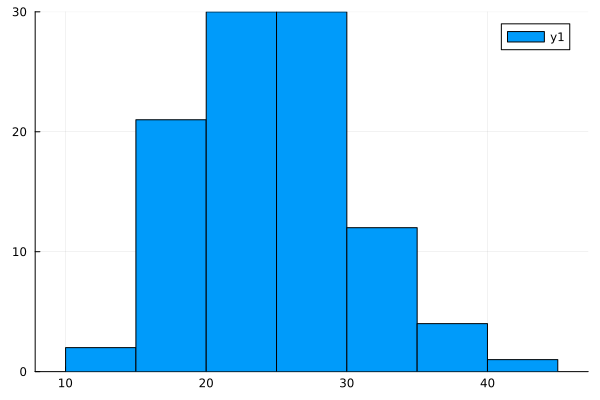

In [50]:
histogram([nv(g) for (key, g) in pruned])

# Densest At-most-k Subgraph

### 1. True DamkS

In [51]:
function exact_daks(g, k)
    # Exact algorithm to find the densest at-k subgraph
    best_g = nothing
    max_d = 0
    for vec in combinations(1:nv(g), k)
        h, vmap = induced_subgraph(g, vec)
        if density(h) > max_d
            best_g = h
            max_d = density(h)
        end
    end
    best_g
end

function exact_damks(g, k)
    # Exact algorithm to find the densest at-most-k subgraph
    best_g = nothing
    max_d = 0
    for ks in 2:k
        h = exact_daks(g, ks)
        if density(h) > max_d
            max_d = density(h)
            best_g = h
        end
    end
    best_g
end

function true_densities(graphs, k)
    # Exact algorithm to find the density of DamkS
    res = Dict{String, Float64}()
    for (name, g) in graphs
        res[name] = exact_damks(g, k)
    end
    res
end

function true_densities_mt(graphs, K)
    # From ChatGPT. Need to verify
    ts = [Dict{Int,Int}() for _ in 1:Threads.nthreads()]
    Threads.@threads for key in keys(pruned)
        tid = Threads.threadid()
        ts[tid][i] = exact_damks(g, k)
    end
    reduce(merge!, ts)
end

true_densities_mt (generic function with 1 method)

Test on graph "1"

Density = 5.466666666666667


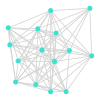

In [52]:
# g = graphs["1"]
g = pruned["1"]
# gplot(g)
h = exact_damks(g, K)
print("Density = ")
println(density(h))
gplot(h)

Run

In [ ]:
# target = true_densities(graphs, K)
target = true_densities_mt(graphs, K)